## EDA

### Contextualización del dataset

Las enfermedades cardiovasculares son la causa número 1 de muerte globalmente, matando aproximadamente a 17.9 millones de personas cada año, correspondientes a un 31% de todas las muertes a nivel mundial. 4 de cada 5 muertes por enfermedades cardiovasculares son gracias a ataques al corazón y strokes, y un tercio de estas muertes ocurren prematuramente a individuos menores de 70 años. 

Una falla en el corazón es un evento común causado por enfermedades cardiovasculares, y este dataset contiene 11 características que pueden ser usadas para predecir una posible enfermedad del corazón.

### Características (variables) disponibles para la predicción

Dentro del dataset contamos con 11 características y una variable objetivo, las cuales son:

**Características**: 

- `Age`: Edad del paciente en años
- `Sex`: Sexo del paciente [M: Male, F: Female]
- `ChestPainType`: Tipo de dolor en el pecho del paciente: [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- `RestingBP`: Presión arterial en reposo
- `Cholesterol`: Nivel de colesterol en sangre
- `FastingBS`: Nivel de azúcar en sangre en ayunas: [1: si FastingBS > 120 mg/dl, 0: en otro caso]
- `RestingECG`: Resultados del electrocardiograma en reposo [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- `MaxHR`: Máxima frecuencia cardíaca registrada
- `ExerciseAngina`: angina inducida por el ejercicio [Y: Yes, N: No]
- `OldPeak`: Depresión del segmento ST
- `ST_Slope`: Pendiente del segmento ST del ejercicio máximo

**Variable objetivo**:
- `HeartDisease`: Tiene o no una enfermedad en el corazón: [1: enfermo, 0: Sano]


### Objetivo

El objetivo de este miniproyecto es, por medio de distintos modelos de machine learning como k-NN, regresión logística o random forest, predecir si con base en las características disponibles, una persona tiene una enfermedad al corazón o no.

### Análisis del dataset

Este dataset reposa en `Kaggle` en el siguiente link:
https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

Para facilitar la reproducción del notebook, el dataset se subió a GitHub de tal manera que solo es necesario importarlo directamente desde internet.

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [73]:
import janitor as jn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, average_precision_score
from sklearn.neighbors import KNeighborsClassifier

In [74]:
df=pd.read_csv("https://raw.githubusercontent.com/hector3910/miniproyecto_pipelines/refs/heads/main/heart.csv")

df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Veamos con `.info()` información relevante del dataset:

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


Algunos hallazgos importantes de este análisis son:

- **El tamaño del dataset**: El dataset cuenta con 918 instancias y 12 variables, ya descritas en la contextualización.
- **Valores faltantes**: No se encontró ningún valor faltante en el dataset, por lo que no es necesario realizar imputaciones.

- **Tipos de variables**: Sin contar la variable objetivo la cual es binaria, el dataset cuenta con 5 variables numéricas: `Age` (`int64`), `RestingBP` (`int64`), `Cholesterol` (`int64`),  `MaxHR` (`int64`) y `Oldpeak` (`float64`). Además cuenta también con 6 variables categóricas: `Sex`, `ChestPainType`, `RestingECG`, `ExerciseAngina`, `ST_Slope`, `FastingBS` (`int64`). Esta última es numérica pero convertida a binaria bajo una condición, si su valor es mayor a 120 registra 1, en otro caso es 0, por lo que se considera como categórica.

In [76]:
df[df.duplicated(keep=False)]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease


Además, tampoco cuenta con valores duplicados, por lo que podemos pasar a un resumen numérico del dataset con `.describe()`.

### Análisis univariado

In [77]:
cat_cols=['Sex','ChestPainType', 'RestingECG', 'ExerciseAngina','ST_Slope','FastingBS']

num_cols=['Age', 'RestingBP', 'Cholesterol',  'MaxHR','Oldpeak']

#### Variables numéricas

In [78]:
df.drop(["HeartDisease","FastingBS"],axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2


No parecen haber rangos erróneos para las variables numéricas.

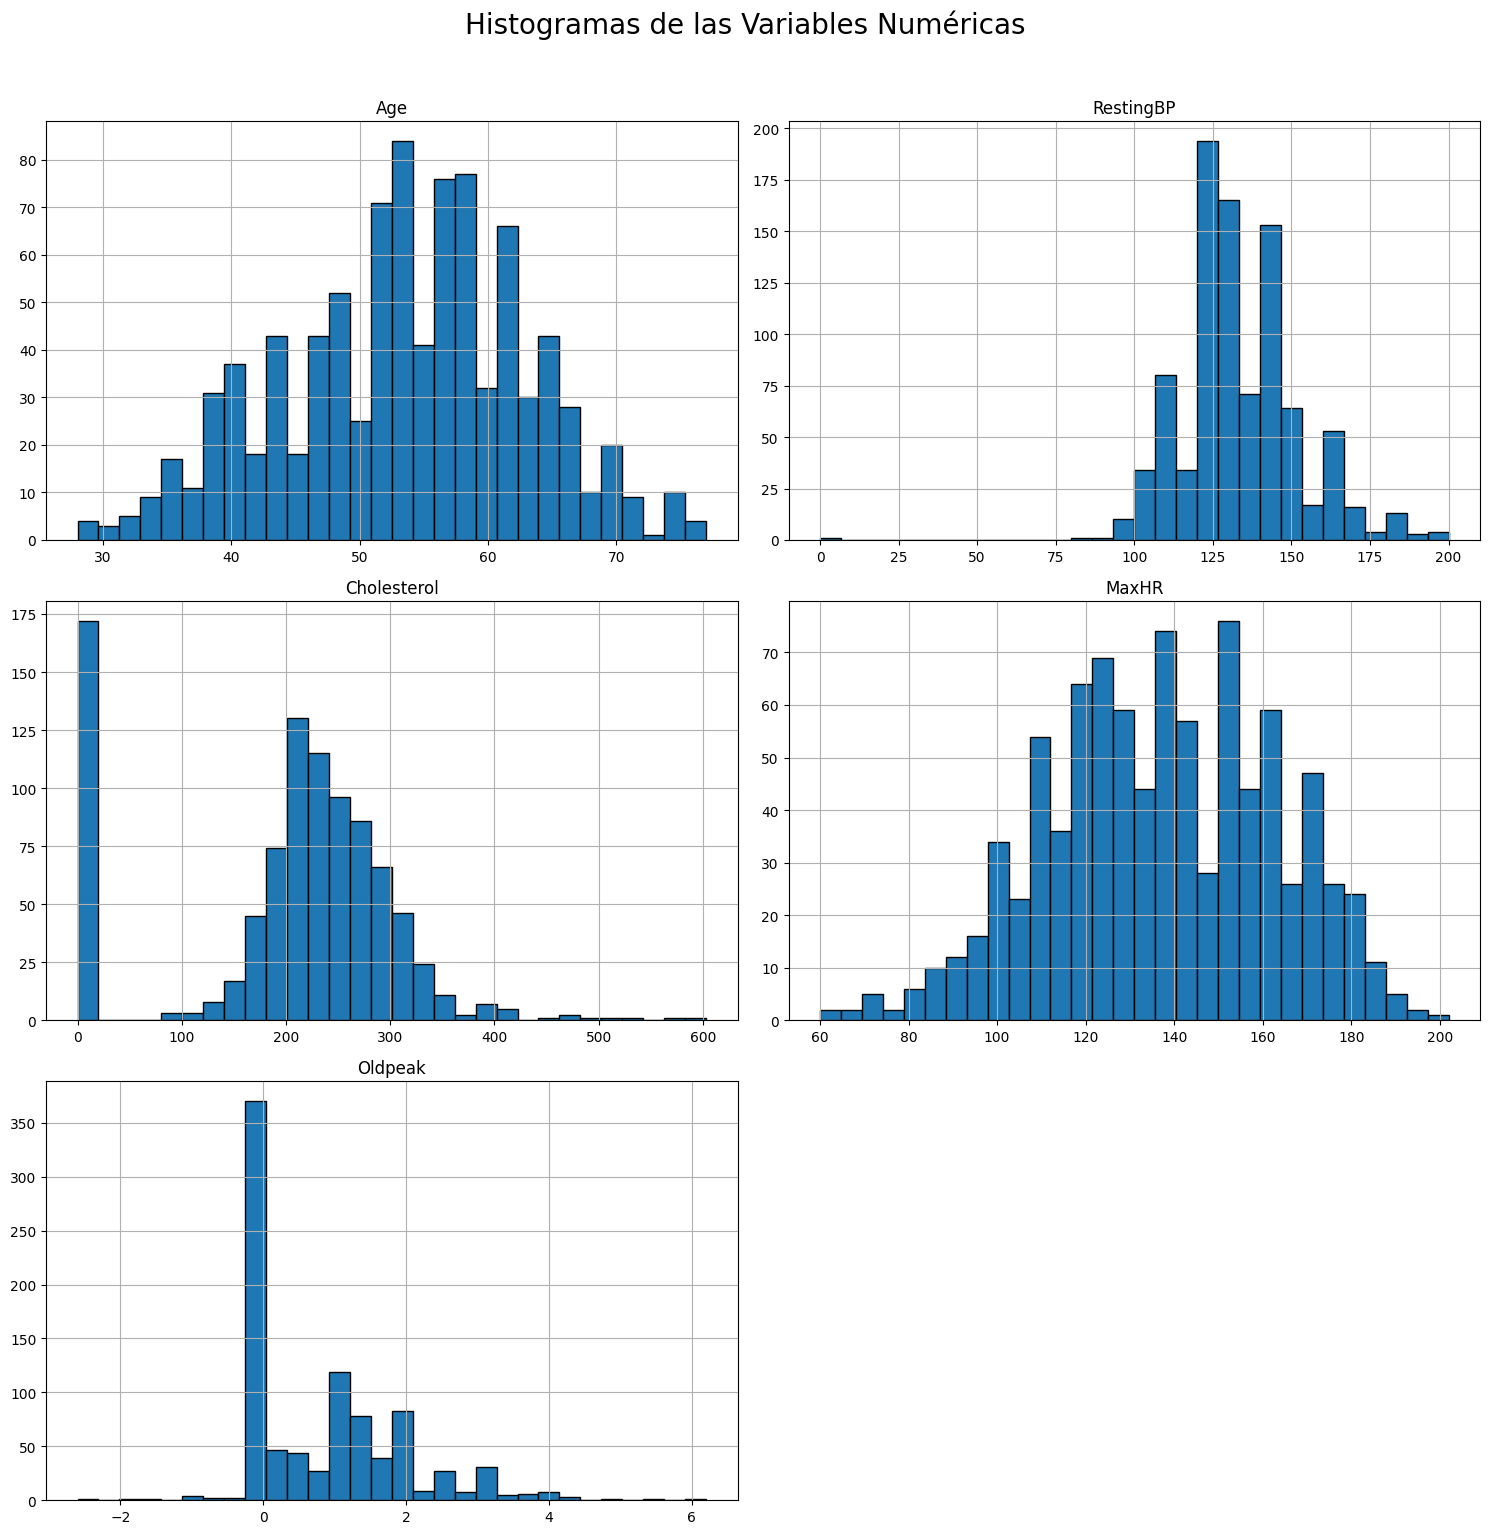

In [79]:
df[num_cols].hist(bins=30, figsize=(15, 15), layout=(-1, 2), edgecolor='black')
plt.suptitle('Histogramas de las Variables Numéricas', size=20, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

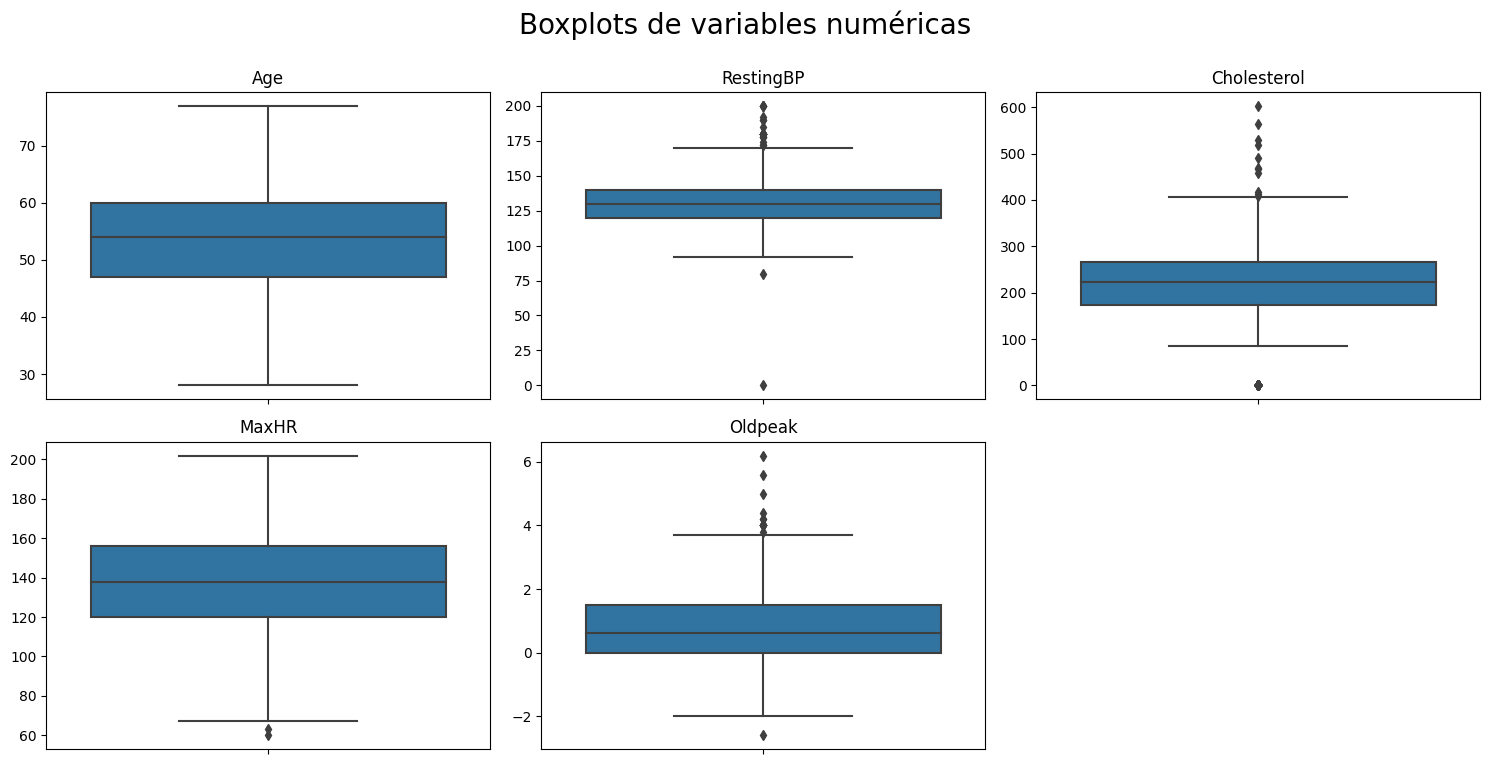

In [80]:
plt.figure(figsize=(15, 12))
plt.suptitle('Boxplots de variables numéricas', size=20, y=0.95)

for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[col])
    plt.title(col)
    plt.ylabel('')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### Variables categóricas

In [81]:
for column in cat_cols:
    print(df[column].value_counts())
    print("\n")

Sex
M    725
F    193
Name: count, dtype: int64


ChestPainType
ASY    496
NAP    203
ATA    173
TA      46
Name: count, dtype: int64


RestingECG
Normal    552
LVH       188
ST        178
Name: count, dtype: int64


ExerciseAngina
N    547
Y    371
Name: count, dtype: int64


ST_Slope
Flat    460
Up      395
Down     63
Name: count, dtype: int64


FastingBS
0    704
1    214
Name: count, dtype: int64




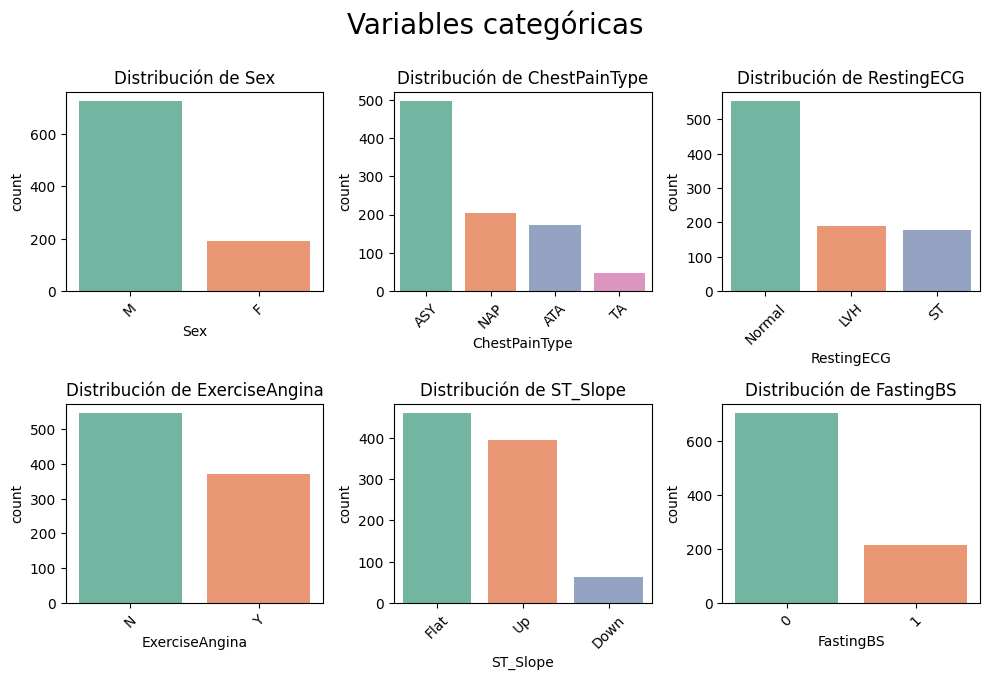

In [82]:
plt.figure(figsize=(10, 10))
plt.suptitle('Variables categóricas', size=20, y=0.95)

for i,col in enumerate(cat_cols, 1):
    plt.subplot(3, 3, i)
    sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="Set2")
    plt.title(f"Distribución de {col}")
    plt.xticks(rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [83]:
df["HeartDisease"].value_counts()

HeartDisease
1    508
0    410
Name: count, dtype: int64

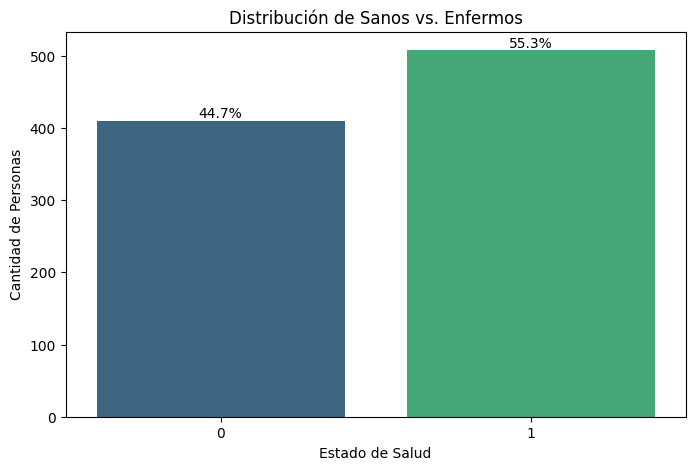

In [84]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='HeartDisease', data=df, palette='viridis')
plt.title('Distribución de Sanos vs. Enfermos')
plt.xlabel('Estado de Salud')
plt.ylabel('Cantidad de Personas')

total = len(df['HeartDisease'])
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.show()



### Análisis bivariado

#### Numéricas vs el target

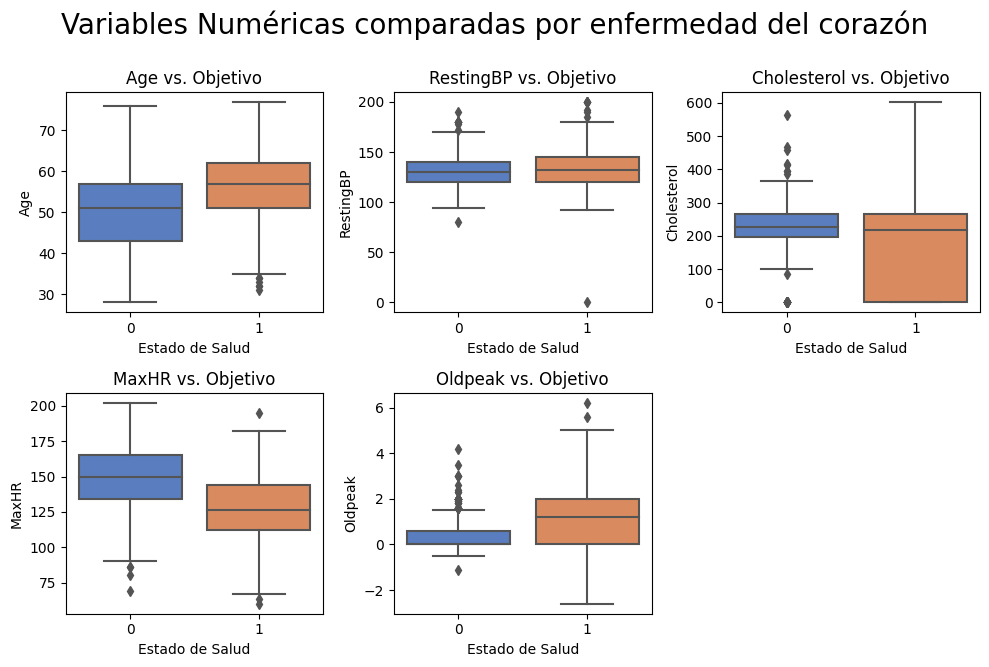

In [85]:
plt.figure(figsize=(10, 10))
plt.suptitle('Variables Numéricas comparadas por enfermedad del corazón', size=20, y=0.95)

for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x='HeartDisease', y=col, data=df, palette='muted')
    plt.title(f'{col} vs. Objetivo')
    plt.xlabel('Estado de Salud')
    plt.ylabel(col)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Categóricas vs el target

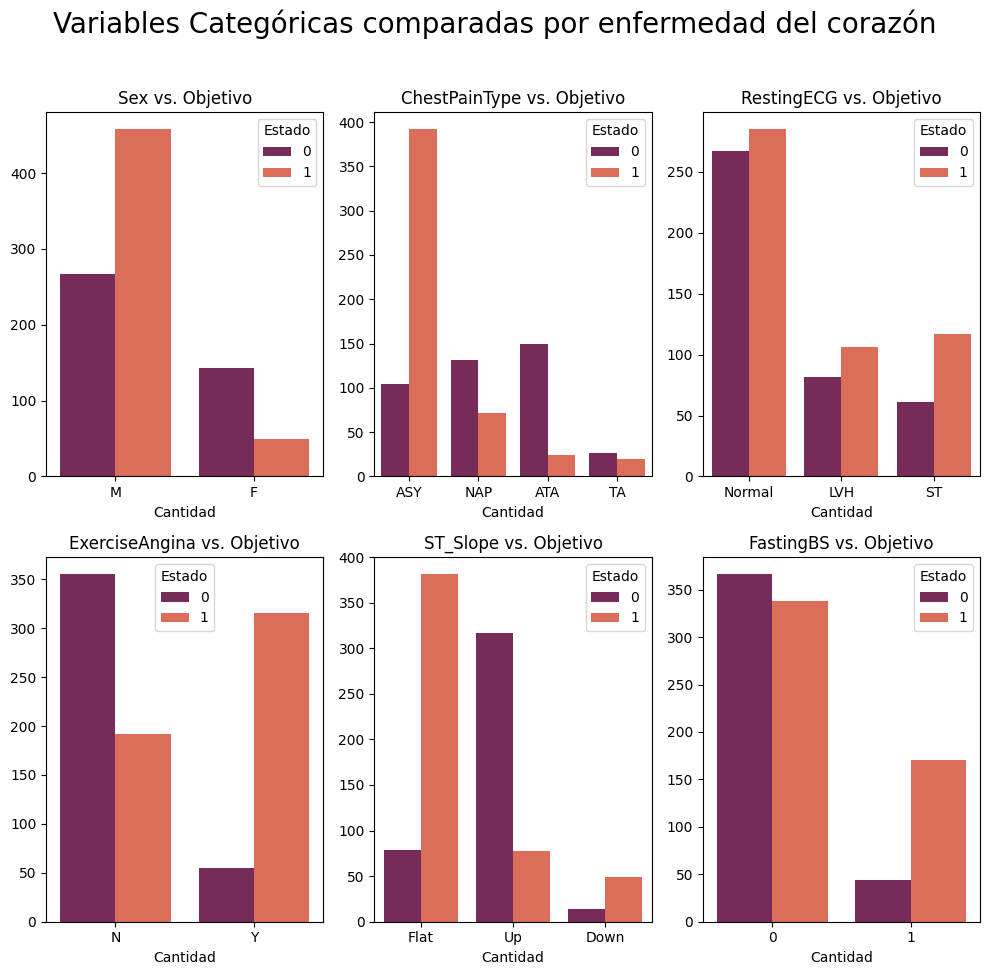

In [86]:

ncols = 3 

n_features = len(cat_cols)
nrows = (n_features + ncols - 1) // ncols

plt.figure(figsize=(10, nrows * 5))
plt.suptitle('Variables Categóricas comparadas por enfermedad del corazón', size=20, y=1.0)

for i, col in enumerate(cat_cols, 1):

    plt.subplot(nrows, ncols, i)
    sns.countplot(x=col, data=df, hue='HeartDisease', order=df[col].value_counts().index, palette='rocket')
    plt.title(f'{col} vs. Objetivo')
    plt.xlabel('Cantidad')
    plt.ylabel('')
    plt.legend(title='Estado')

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

### Análisis multivariado

#### Matriz de correlación

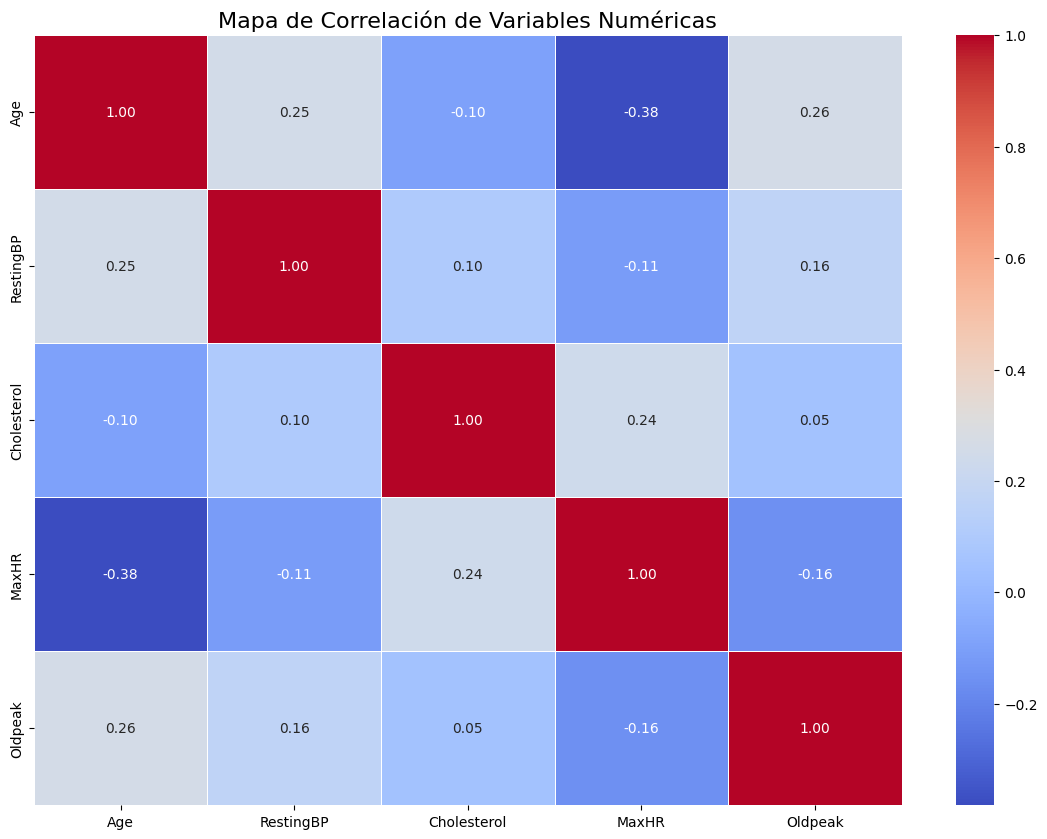

In [87]:
correlation_matrix = df[num_cols].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Mapa de Correlación de Variables Numéricas', size=16)
plt.show()

### Modelo logístico

In [208]:
#Separamos las características del target

X=df.drop(columns="HeartDisease")
y=df["HeartDisease"]

In [209]:
#División en train y test
X_train, X_test, y_train, y_test= train_test_split(X,y, stratify=y,random_state=42)

In [210]:
preprocessor=ColumnTransformer( 
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

pipeline=Pipeline([
    ("preprocessor", preprocessor),
    ("logistic", LogisticRegression(max_iter=1000))
    
])

param_grid_pipe={
    "logistic__penalty": ["l1", "l2"],
    "logistic__C": [0.01, 0.1, 1, 10, 100]
}

In [211]:
kfold=StratifiedKFold(n_splits=5)
grid_pipe_log=GridSearchCV(pipeline, param_grid_pipe, cv=kfold, scoring="roc_auc", n_jobs=-1, verbose=1)
grid_pipe_log.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'RestingBP',
                                                                          'Cholesterol',
                                                                          'MaxHR',
                                                                          'Oldpeak']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Sex',
                                                                          'ChestPainType',
                                                                          'RestingECG',
                                                                          'ExerciseAngina',
                                                                          'ST_Slope',
                                                                          'FastingBS'])])),
                                       ('logistic',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'logistic__C': [0.01, 0.1, 1, 10, 100],
                         'logistic__penalty': ['l1', 'l2']},
             scoring='roc_auc', verbose=1)

In [212]:
print("Best parameter: {}".format(grid_pipe_log.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_pipe_log.best_score_))

Best parameter: {'logistic__C': 0.1, 'logistic__penalty': 'l2'}
Best cross-validation score: 0.92


In [213]:
best_model = grid_pipe_log.best_estimator_

# Reentrenar con el X_train completo
best_model.fit(X_train, y_train)

# Evaluar en el test reservado
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
print("\n Reporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=['healthy', 'diseased'],digits=3))



 Reporte de clasificación:
              precision    recall  f1-score   support

     healthy      0.887     0.835     0.860       103
    diseased      0.872     0.913     0.892       127

    accuracy                          0.878       230
   macro avg      0.879     0.874     0.876       230
weighted avg      0.879     0.878     0.878       230



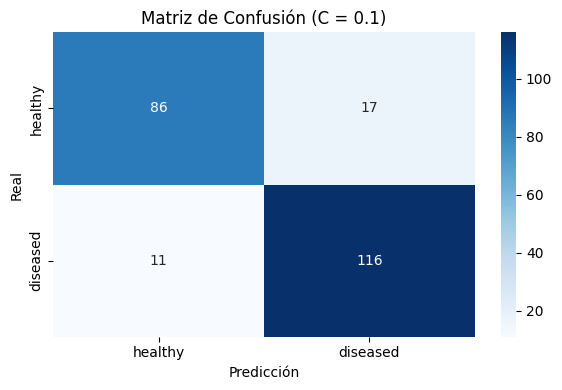

In [ ]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',  
            xticklabels=['healthy', 'diseased'],
            yticklabels=['healthy', 'diseased'])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title(f"Matriz de Confusión (C = {list(grid_pipe_log.best_params_.values())[0]})")
plt.tight_layout()
plt.show()

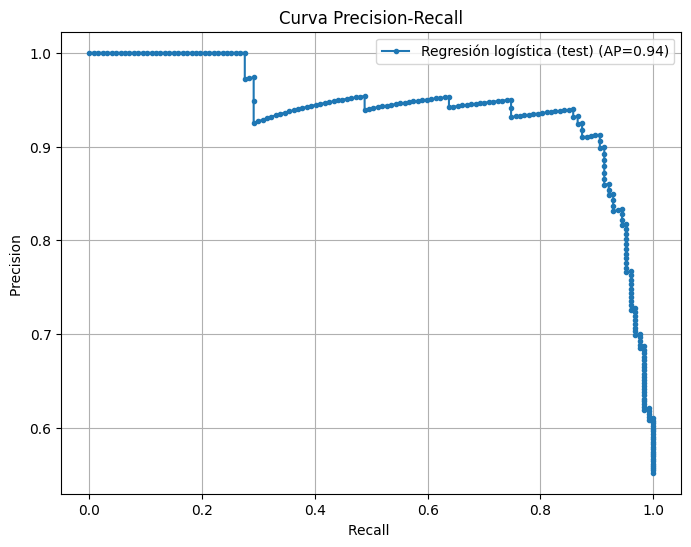

In [215]:
# Calcular precision y recall para diferentes umbrales
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Calcular promedio (Average Precision Score)
avg_precision = average_precision_score(y_test, y_proba)

# Graficar curva Precision-Recall
plt.figure(figsize=(8,6)) 
plt.plot(recall, precision, marker='.', label=f'Regresión logística (test) (AP={avg_precision:.2f})')
plt.xlabel('Recall ')
plt.ylabel('Precision ')
plt.title('Curva Precision-Recall')
plt.legend()
plt.grid(True)
plt.show()

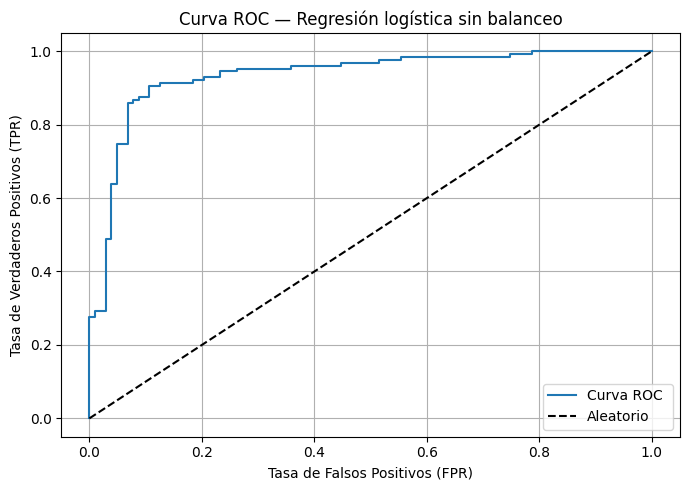

AUC (Área bajo la curva ROC): 0.9342


In [216]:

# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calcular AUC
auc_score = roc_auc_score(y_test, y_proba)

# Graficar curva ROC
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'Curva ROC ')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC — Regresión logística sin balanceo')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"AUC (Área bajo la curva ROC): {auc_score:.4f}")

### k-NN

In [217]:
preprocessor=ColumnTransformer( 
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

pipeline=Pipeline([
    ("preprocessor", preprocessor),
    ("k-nn", KNeighborsClassifier())
    
])

param_grid_pipe={
    "k-nn__n_neighbors": [1,3, 5, 7, 9, 11,13,15,17,19],
    "k-nn__weights": ["uniform", "distance"]
}

In [218]:
kfold=StratifiedKFold(n_splits=5)
grid_pipe_knn=GridSearchCV(pipeline, param_grid_pipe, cv=kfold, scoring="roc_auc", n_jobs=-1, verbose=1)
grid_pipe_knn.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'RestingBP',
                                                                          'Cholesterol',
                                                                          'MaxHR',
                                                                          'Oldpeak']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Sex',
                                                                          'ChestPainType',
                                                                          'RestingECG',
                                                                          'ExerciseAngina',
                                                                          'ST_Slope',
                                                                          'FastingBS'])])),
                                       ('k-nn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'k-nn__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17,
                                               19],
                         'k-nn__weights': ['uniform', 'distance']},
             scoring='roc_auc', verbose=1)

In [219]:
print("Best parameter: {}".format(grid_pipe_knn.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_pipe_knn.best_score_))

Best parameter: {'k-nn__n_neighbors': 19, 'k-nn__weights': 'uniform'}
Best cross-validation score: 0.92


In [220]:
best_model = grid_pipe_knn.best_estimator_

# Reentrenar con el X_train completo
best_model.fit(X_train, y_train)

# Evaluar en el test reservado
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
print("\n Reporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=['healthy', 'diseased'], digits=3))



 Reporte de clasificación:
              precision    recall  f1-score   support

     healthy      0.927     0.864     0.894       103
    diseased      0.896     0.945     0.920       127

    accuracy                          0.909       230
   macro avg      0.911     0.904     0.907       230
weighted avg      0.910     0.909     0.908       230



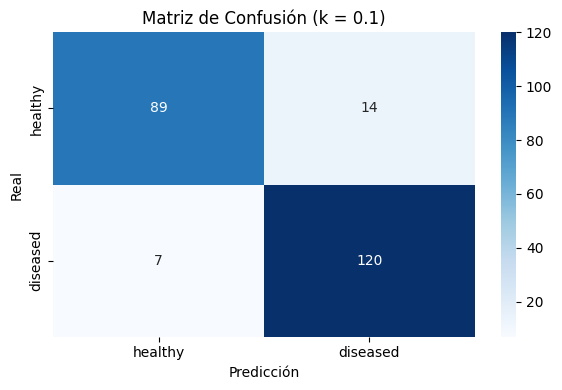

In [ ]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',  
            xticklabels=['healthy', 'diseased'],
            yticklabels=['healthy', 'diseased'])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title(f"Matriz de Confusión (k = {list(grid_pipe_knn.best_params_.values())[0]})")
plt.tight_layout()
plt.show()

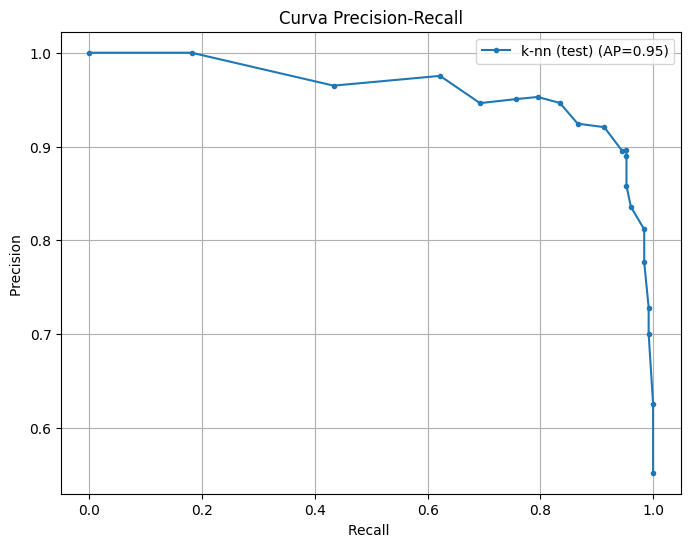

In [222]:
# Calcular precision y recall para diferentes umbrales
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Calcular promedio (Average Precision Score)
avg_precision = average_precision_score(y_test, y_proba)

# Graficar curva Precision-Recall
plt.figure(figsize=(8,6)) 
plt.plot(recall, precision, marker='.', label=f'k-nn (test) (AP={avg_precision:.2f})')
plt.xlabel('Recall ')
plt.ylabel('Precision ')
plt.title('Curva Precision-Recall')
plt.legend()
plt.grid(True)
plt.show()

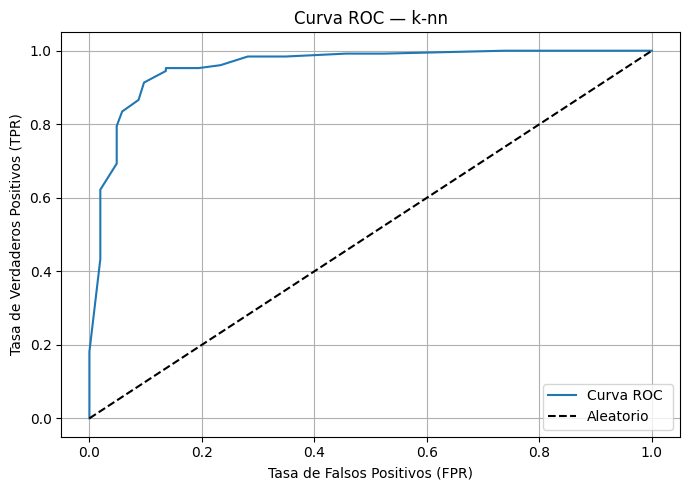

AUC (Área bajo la curva ROC): 0.9571


In [223]:

# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calcular AUC
auc_score = roc_auc_score(y_test, y_proba)

# Graficar curva ROC
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'Curva ROC ')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC — k-nn')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"AUC (Área bajo la curva ROC): {auc_score:.4f}")

### Clasificador bayesiano

In [224]:
from sklearn.naive_bayes import GaussianNB

In [225]:
preprocessor=ColumnTransformer( 
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

pipeline=Pipeline([
    ("preprocessor", preprocessor),
    ("gb", GaussianNB())
    
])

param_grid_pipe={}

In [226]:
kfold=StratifiedKFold(n_splits=5)
grid_pipe_bayes=GridSearchCV(pipeline, param_grid_pipe, cv=kfold, scoring="roc_auc", n_jobs=-1, verbose=1)
grid_pipe_bayes.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'RestingBP',
                                                                          'Cholesterol',
                                                                          'MaxHR',
                                                                          'Oldpeak']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Sex',
                                                                          'ChestPainType',
                                                                          'RestingECG',
                                                                          'ExerciseAngina',
                                                                          'ST_Slope',
                                                                          'FastingBS'])])),
                                       ('gb', GaussianNB())]),
             n_jobs=-1, param_grid={}, scoring='roc_auc', verbose=1)

In [227]:
print("Best parameter: {}".format(grid_pipe_bayes.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_pipe_bayes.best_score_))

Best parameter: {}
Best cross-validation score: 0.91


In [228]:
best_model = grid_pipe_bayes.best_estimator_

# Reentrenar con el X_train completo
best_model.fit(X_train, y_train)

# Evaluar en el test reservado
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
print("\n Reporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=['healthy', 'diseased'], digits=3))



 Reporte de clasificación:
              precision    recall  f1-score   support

     healthy      0.879     0.845     0.861       103
    diseased      0.878     0.906     0.891       127

    accuracy                          0.878       230
   macro avg      0.878     0.875     0.876       230
weighted avg      0.878     0.878     0.878       230



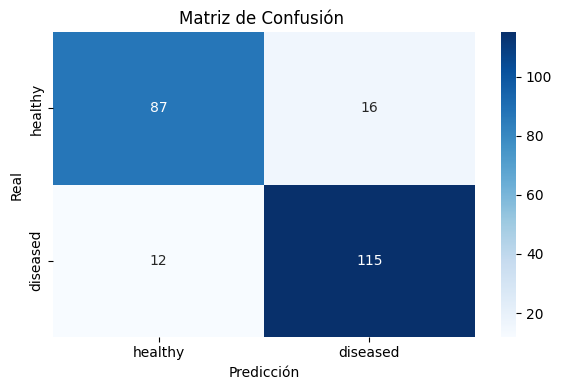

In [229]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',  
            xticklabels=['healthy', 'diseased'],
            yticklabels=['healthy', 'diseased'])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title(f"Matriz de Confusión ")
plt.tight_layout()
plt.show()

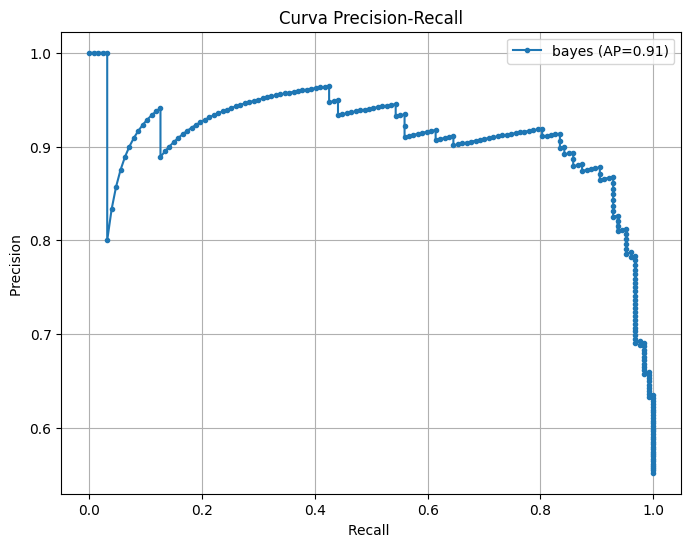

In [230]:
# Calcular precision y recall para diferentes umbrales
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Calcular promedio (Average Precision Score)
avg_precision = average_precision_score(y_test, y_proba)

# Graficar curva Precision-Recall
plt.figure(figsize=(8,6)) 
plt.plot(recall, precision, marker='.', label=f'bayes (AP={avg_precision:.2f})')
plt.xlabel('Recall ')
plt.ylabel('Precision ')
plt.title('Curva Precision-Recall')
plt.legend()
plt.grid(True)
plt.show()

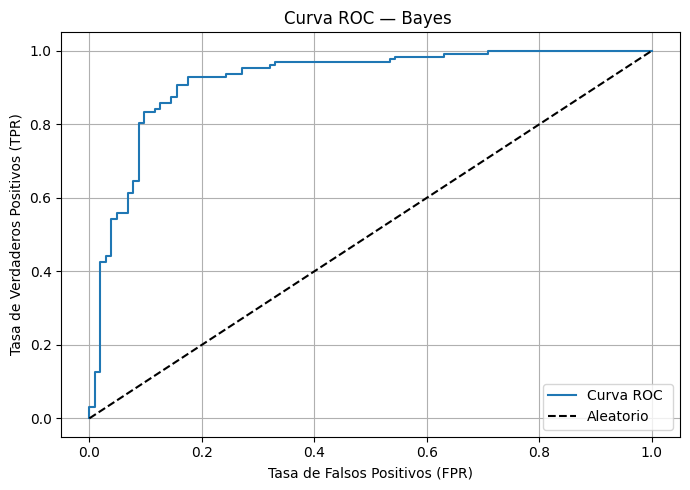

AUC (Área bajo la curva ROC): 0.9205


In [231]:

# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calcular AUC
auc_score = roc_auc_score(y_test, y_proba)

# Graficar curva ROC
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'Curva ROC ')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC — Bayes ')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"AUC (Área bajo la curva ROC): {auc_score:.4f}")

### Random Forest

In [232]:
from sklearn.ensemble import RandomForestClassifier

In [233]:
preprocessor=ColumnTransformer( 
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

pipeline=Pipeline([
    ("preprocessor", preprocessor),
    ("random_forest", RandomForestClassifier(random_state=42))
    
])

param_grid_pipe={
    "random_forest__n_estimators": [10, 50, 100],
    "random_forest__max_depth": [5,10,15]
}

In [234]:
kfold=StratifiedKFold(n_splits=5)
grid_pipe_forest=GridSearchCV(pipeline, param_grid_pipe, cv=kfold, scoring="roc_auc", n_jobs=-1, verbose=1)
grid_pipe_forest.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Sex',
                                                                          'ChestPainType',
                                                                          'RestingECG',
                                                                          'ExerciseAngina',
                                                                          'ST_Slope',
                                                                          'FastingBS'])])),
                                       ('random_forest',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'random_forest__max_depth': [5, 10, 15],
                         'random_forest__n_estimators': [10, 50, 100]},
             scoring='roc_auc', verbose=1)

In [235]:
print("Best parameter: {}".format(grid_pipe_forest.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_pipe_forest.best_score_))

Best parameter: {'random_forest__max_depth': 5, 'random_forest__n_estimators': 50}
Best cross-validation score: 0.92


In [236]:
best_model = grid_pipe_forest.best_estimator_

# Reentrenar con el X_train completo
best_model.fit(X_train, y_train)

# Evaluar en el test reservado
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
print("\n Reporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=['healthy', 'diseased'], digits=3))



 Reporte de clasificación:
              precision    recall  f1-score   support

     healthy      0.912     0.806     0.856       103
    diseased      0.856     0.937     0.895       127

    accuracy                          0.878       230
   macro avg      0.884     0.871     0.875       230
weighted avg      0.881     0.878     0.877       230



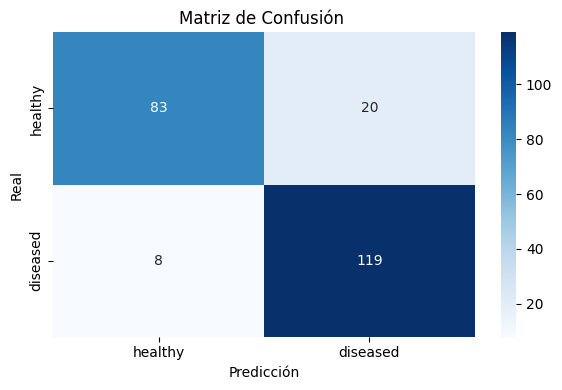

In [237]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',  
            xticklabels=['healthy', 'diseased'],
            yticklabels=['healthy', 'diseased'])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title(f"Matriz de Confusión ")
plt.tight_layout()
plt.show()

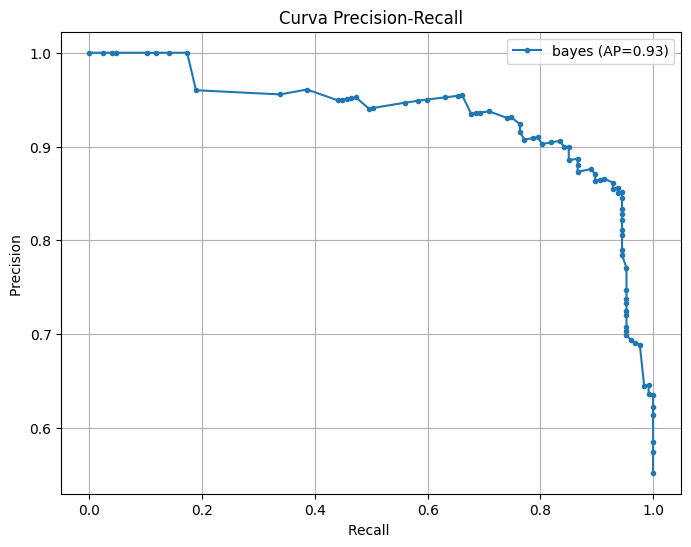

In [238]:
# Calcular precision y recall para diferentes umbrales
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Calcular promedio (Average Precision Score)
avg_precision = average_precision_score(y_test, y_proba)

# Graficar curva Precision-Recall
plt.figure(figsize=(8,6)) 
plt.plot(recall, precision, marker='.', label=f'bayes (AP={avg_precision:.2f})')
plt.xlabel('Recall ')
plt.ylabel('Precision ')
plt.title('Curva Precision-Recall')
plt.legend()
plt.grid(True)
plt.show()

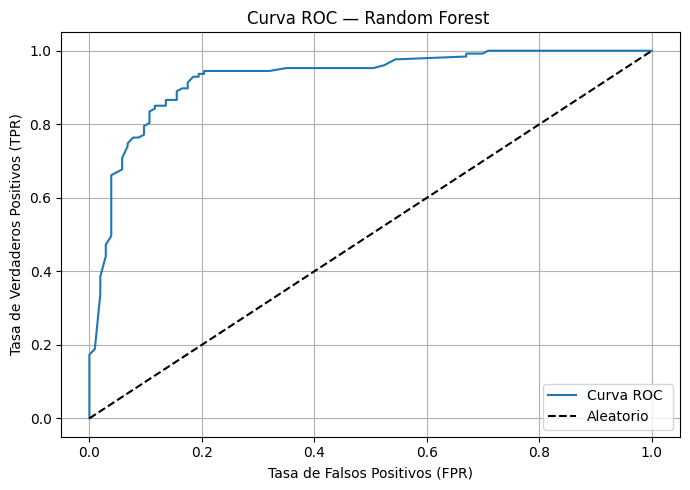

AUC (Área bajo la curva ROC): 0.9256


In [239]:

# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calcular AUC
auc_score = roc_auc_score(y_test, y_proba)

# Graficar curva ROC
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'Curva ROC ')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC — Random Forest ')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"AUC (Área bajo la curva ROC): {auc_score:.4f}")

### XGBoost

In [240]:
from sklearn.ensemble import GradientBoostingClassifier

In [241]:
preprocessor=ColumnTransformer( 
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

pipeline=Pipeline([
    ("preprocessor", preprocessor),
    ("gradient_boost", GradientBoostingClassifier(random_state=42))
    
])
param_grid_pipe = {
    'gradient_boost__max_depth': [1,2,3, 4, 5, 6, 7],  # Rango para la profundidad del árbol
    'gradient_boost__learning_rate': [0.01,0.1, 0.2, 0.3],  # Rango para la tasa de aprendizaje
    'gradient_boost__n_estimators': [5,10,50,100],  # Número de árboles a entrenar
}

In [242]:
kfold=StratifiedKFold(n_splits=5)
grid_pipe_xgb=GridSearchCV(pipeline, param_grid_pipe, cv=kfold, scoring="roc_auc", n_jobs=-1, verbose=1)
grid_pipe_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 112 candidates, totalling 560 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Sex',
                                                                          'ChestPainType',
                                                                          'RestingECG',
                                                                          'ExerciseAngina',
                                                                          'ST_Slope',
                                                                          'FastingBS'])])),
                                       ('gradient_boost',
                                        GradientBoostingClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'gradient_boost__learning_rate': [0.01, 0.1, 0.2, 0.3],
                         'gradient_boost__max_depth': [1, 2, 3, 4, 5, 6, 7],
                         'gradient_boost__n_estimators': [5, 10, 50, 100]},
             scoring='roc_auc', verbose=1)

In [243]:
print("Best parameter: {}".format(grid_pipe_xgb.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_pipe_xgb.best_score_))

Best parameter: {'gradient_boost__learning_rate': 0.1, 'gradient_boost__max_depth': 1, 'gradient_boost__n_estimators': 100}
Best cross-validation score: 0.92


In [244]:
best_model = grid_pipe_xgb.best_estimator_

# Reentrenar con el X_train completo
best_model.fit(X_train, y_train)

# Evaluar en el test reservado
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
print("\n Reporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=['healthy', 'diseased'], digits=3))



 Reporte de clasificación:
              precision    recall  f1-score   support

     healthy      0.923     0.816     0.866       103
    diseased      0.863     0.945     0.902       127

    accuracy                          0.887       230
   macro avg      0.893     0.880     0.884       230
weighted avg      0.890     0.887     0.886       230



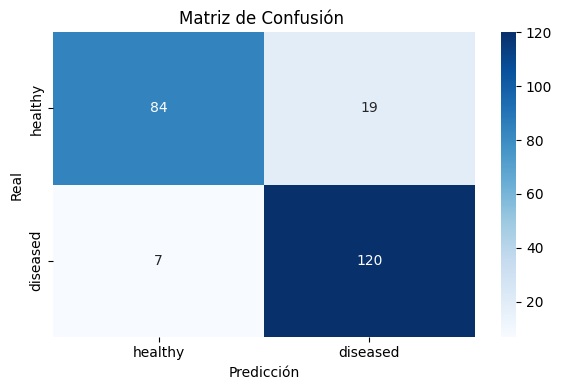

In [245]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',  
            xticklabels=['healthy', 'diseased'],
            yticklabels=['healthy', 'diseased'])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title(f"Matriz de Confusión ")
plt.tight_layout()
plt.show()

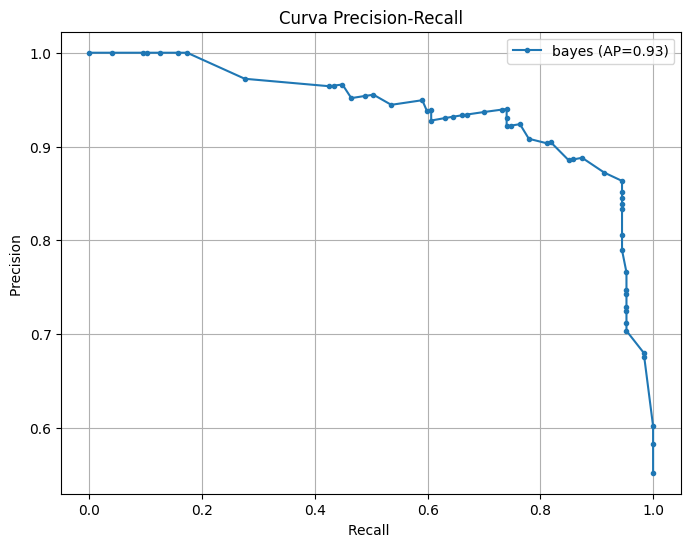

In [246]:
# Calcular precision y recall para diferentes umbrales
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Calcular promedio (Average Precision Score)
avg_precision = average_precision_score(y_test, y_proba)

# Graficar curva Precision-Recall
plt.figure(figsize=(8,6)) 
plt.plot(recall, precision, marker='.', label=f'bayes (AP={avg_precision:.2f})')
plt.xlabel('Recall ')
plt.ylabel('Precision ')
plt.title('Curva Precision-Recall')
plt.legend()
plt.grid(True)
plt.show()

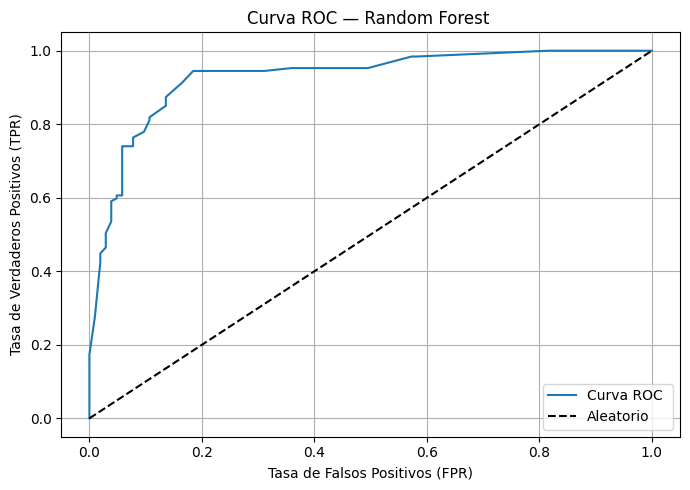

AUC (Área bajo la curva ROC): 0.9274


In [247]:

# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calcular AUC
auc_score = roc_auc_score(y_test, y_proba)

# Graficar curva ROC
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'Curva ROC ')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC — Random Forest ')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"AUC (Área bajo la curva ROC): {auc_score:.4f}")

### Obtenemos el mejor modelo para importarlo a docker

In [ ]:
best_model = grid_pipe_knn.best_estimator_

In [253]:
# Importamos el mejor modelo:
import joblib
joblib.dump(best_model, "C:/ML/projects/heart-disease-mlops/app/model.joblib")

['C:/ML/projects/heart-disease-mlops/app/model.joblib']